In [35]:
import datetime as dt
from authenticate import authenticate_google_calendar 
import matplotlib.pyplot as plt
from googleapiclient.errors import HttpError

# api stuff

In [36]:
def fetch_calendar_names(service):
    calendar_list = service.calendarList().list().execute()
    calendars = calendar_list.get('items', [])
    return {calendar['id']: calendar['summary'] for calendar in calendars}

calendar_name_map = fetch_calendar_names(authenticate_google_calendar())
# calendar_name_map

In [37]:
def fetch_study_events(service, calendar_id, num_previous_days=30):
    now = dt.datetime.utcnow().isoformat() + "Z"  # 'Z' indicates UTC time
    start_date = dt.datetime.utcnow() - dt.timedelta(days=num_previous_days)
    start_date_iso = start_date.isoformat() + "Z"

    # print(f"Fetching events from {calendar_id} for the past {num_previous_days} days")
    events_result = (
        service.events()
        .list(
            calendarId=calendar_id,
            timeMin=start_date_iso,
            timeMax=now,
            maxResults=10000,
            singleEvents=True,
            orderBy="startTime",
        )
        .execute()
    )
    events = events_result.get("items", [])
    print(f"Found {len(events)} events in the past {num_previous_days} days from {calendar_name_map[calendar_id]}.")

    return events

In [38]:
def get_all_studying_hours_today(service, calendar_id):
    # Get the current local timezone
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo

    # Get today's date in the correct format
    today_start = dt.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    today_end = dt.datetime.now().replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()
    
    # Fetch events happening today
    try:
        events_result = service.events().list(calendarId=calendar_id, timeMin=today_start, timeMax=today_end, singleEvents=True, orderBy='startTime').execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return
    
    events = events_result.get('items', [])
    
    if not events:
        print("No events found for today.")
        return
    
    # Calculate total studying hours
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        start_time = dt.datetime.fromisoformat(start)
        end_time = dt.datetime.fromisoformat(end)
        duration = end_time - start_time
        total_hours += duration.total_seconds() / 3600
    
    print(f"Total studying hours scheduled for today: {total_hours:.1f} hours")
    return total_hours

def get_studying_hours_completed_today(service, calendar_id):
    # Get the current local timezone
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo

    # Get today's date for the start of the day and current time
    today_start = dt.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    now = dt.datetime.now(tz=local_timezone).isoformat()

    # Fetch events happening today up until now
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=today_start,
                timeMax=now,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return

    events = events_result.get('items', [])

    if not events:
        print("No events found for today.")
        return 0

    # Calculate total studying hours
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        start_time = dt.datetime.fromisoformat(start)
        end_time = dt.datetime.fromisoformat(end)
        # Ensure the event has ended before adding to total hours
        if end_time <= dt.datetime.now(tz=local_timezone):
            duration = end_time - start_time
            total_hours += duration.total_seconds() / 3600

    print(f"Total studying hours completed today: {total_hours:.1f} hours")
    return total_hours

def fetch_daily_studying_hours(service, calendar_id, date):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    start_of_day = date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    end_of_day = date.replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()

    # Attempt to fetch events for the specified day
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=start_of_day,
                timeMax=end_of_day,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0  # Return 0 hours if an error occurs

    events = events_result.get('items', [])
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        # Parse the datetime strings into datetime objects
        start_time = dt.datetime.fromisoformat(start)
        end_time = dt.datetime.fromisoformat(end)
        # Calculate duration in hours
        duration = (end_time - start_time).total_seconds() / 3600
        total_hours += duration

    return total_hours

def fetch_daily_subject_hours(service, calendar_id, subject, subject_terms, date):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    start_of_day = date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    end_of_day = date.replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()

    # Attempt to fetch events for the specified day
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=start_of_day,
                timeMax=end_of_day,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0  # Return 0 hours if an error occurs

    events = events_result.get('items', [])
    total_hours = 0

    if subject not in subject_terms:
        print(f"Subject '{subject}' not recognized.")
        return 0

    terms = subject_terms[subject]

    for event in events:
        summary = event.get("summary", "").lower()
        if any(term.lower() in summary for term in terms):
            start = event['start'].get('dateTime', event['start'].get('date'))
            end = event['end'].get('dateTime', event['end'].get('date'))
            # Parse the datetime strings into datetime objects
            start_time = dt.datetime.fromisoformat(start)
            end_time = dt.datetime.fromisoformat(end)
            # Calculate duration in hours
            duration = (end_time - start_time).total_seconds() / 3600
            total_hours += duration

    return total_hours

# main functions

## studying progress

In [39]:
def plot_studying_progress(service, calendar_id):
    # Get the total planned and completed studying hours for today
    planned_hours_today = get_all_studying_hours_today(service, calendar_id)
    completed_hours_today = get_studying_hours_completed_today(service, calendar_id)
    percentage_completed = (completed_hours_today / planned_hours_today) * 100
    print(f"Percentage of planned studying hours completed today: {round(percentage_completed)}%")

    # Today's progress
    plt.figure(figsize=(10, 1))
    plt.barh(['Today'], [completed_hours_today], color='skyblue', label='Completed Hours')
    plt.barh(['Today'], [planned_hours_today - completed_hours_today], left=[completed_hours_today], color='lightgrey', label='Remaining Hours')
    plt.xlabel('Hours')
    plt.title('Today\'s Studying Progress')
    plt.legend()

## studying hours over past month

In [40]:
def plot_studying_hours_over_past_month(service, calendar_id):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    now = dt.datetime.now(tz=local_timezone)

    # Fetch data for the last week and last month
    monthly_days = 30
    weekly_days = 7
    daily_hours_month = []
    daily_hours_week = []
    dates_month = [now - dt.timedelta(days=x) for x in range(monthly_days - 1, -1, -1)]
    dates_week = dates_month[weekly_days:]

    for date in dates_month:
        if date == now:
            daily_hours = get_studying_hours_completed_today(service, calendar_id)
        else:
            daily_hours = fetch_daily_studying_hours(service, calendar_id, date)

        daily_hours_month.append(daily_hours)
        if date in dates_week:
            daily_hours_week.append(daily_hours)

    # Calculate averages and other statistics
    average_hours_month = sum(daily_hours_month) / monthly_days
    average_hours_week = sum(daily_hours_week) / weekly_days
    print(f"Average studying hours over the last month: {average_hours_month:.1f} hours")
    print(f"Average studying hours over the last week: {average_hours_week:.1f} hours")

    # Plotting the results for the last month
    plt.figure(figsize=(10, 10))
    plt.barh([date.strftime("%b %d") for date in dates_month], daily_hours_month, color='skyblue')
    plt.xlabel('Date')
    plt.ylabel('Hours Studied')
    plt.title('Studying Hours Over the Last Month')
    plt.axvline(x=average_hours_month, color='green', linestyle='--', label='Monthly Average')
    plt.axvline(x=average_hours_week, color='darkblue', linestyle='--', label='Weekly Average')
    plt.legend()
    plt.tight_layout()
    plt.show()

## subject specific hours over past month

In [41]:
def plot_subject_hours_over_past_month(service, calendar_id, subject, subjects):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    now = dt.datetime.now(tz=local_timezone)

    # Fetch data for the last week and last month
    monthly_days = 30
    weekly_days = 7
    daily_hours_month = []
    daily_hours_week = []
    dates_month = [now - dt.timedelta(days=x) for x in range(monthly_days - 1, -1, -1)]
    dates_week = dates_month[:weekly_days]

    for date in dates_month:
        if date == now:
            daily_hours = get_studying_hours_completed_today(service, calendar_id)
        else:
            daily_hours = fetch_daily_subject_hours(service, calendar_id, subject, subjects, date)
            
        daily_hours_month.append(daily_hours)
        if date in dates_week:
            daily_hours_week.append(daily_hours)

    # Calculate averages and other statistics
    average_hours_month = sum(daily_hours_month) / monthly_days
    average_hours_week = sum(daily_hours_week) / weekly_days
    print(f"Average studying hours over the last month: {average_hours_month:.1f} hours")
    print(f"Average studying hours over the last week: {average_hours_week:.1f} hours")

    # Plotting the results for the last month
    plt.figure(figsize=(10, 10))
    plt.barh([date.strftime("%b %d") for date in dates_month], daily_hours_month, color='skyblue')
    plt.xlabel('Date')
    plt.ylabel('Hours Studied')
    plt.title(f'{subject} Hours Over the Last Month')
    plt.axvline(x=average_hours_month, color='green', linestyle='--', label='Monthly Average')
    plt.axvline(x=average_hours_week, color='darkblue', linestyle='--', label='Weekly Average')
    plt.legend()
    plt.tight_layout()
    plt.show()

## study stats

### abstractions

In [42]:
def merge_events(events_list):
    merged_events = []
    for events in events_list:
        merged_events.extend(events)
    return merged_events

def fetch_all_events(service, calendar_ids, num_previous_days):
    all_events = []
    for calendar_id in calendar_ids:
        events = fetch_study_events(service, calendar_id, num_previous_days)
        all_events.extend(events)
    return merge_events([all_events])

def calculate_subject_times(merged_events, subjects):
    subjects_time = {subject: 0 for subject in subjects}
    
    for event in merged_events:
        start = dt.datetime.fromisoformat(
            event["start"].get("dateTime", event["start"].get("date"))
        )
        end = dt.datetime.fromisoformat(
            event["end"].get("dateTime", event["end"].get("date"))
        )
        duration = (end - start).total_seconds() / 3600  # Convert to hours

        summary = event.get("summary", "")

        for subject, terms in subjects.items():
            for term in terms:
                if term.lower() in summary.lower():
                    subjects_time[subject] += duration
                    break

    return subjects_time

def plot_study_stats(subjects_time, num_previous_days):
    if sum(subjects_time.values()) == 0:
        print(f"No study time recorded for the past {num_previous_days} days.")
        return

    total_study_time = sum(subjects_time.values())
    print(f"Total study time in the past {num_previous_days} days: {total_study_time} hours")

    for subject, time in subjects_time.items():
        if time > 0:
            print(f"{subject}: {time:.1f} hrs", end=", ")
    print()

    # Generate pie chart and bar chart side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Pie chart
    ax1.pie(
        [x for x in subjects_time.values() if x > 0],
        labels=[x for x in subjects_time if subjects_time[x] > 0],
        autopct="%1.1f%%",
        startangle=90,
    )
    ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")

    # Bar chart
    ax2.bar(subjects_time.keys(), subjects_time.values())
    ax2.set_xlabel("Subjects")
    ax2.set_ylabel("Study Time (hours)")
    ax2.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")
    ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


### running bit

In [43]:
subjects = {
    "Maths": ["maths", "math", "mathematics"],
    "Computer Science": ["computer science", "comp sci", "cs nea", "csc"],
    "Physics": ["physics", "phys"],
    "EPQ": ["epq"],
    "TMUA": ["tmua"],
    "Project Euler": ["project euler"],
    "Medium": ["medium"],
}
def study_stats(service, calendar_ids, num_previous_days=365):
    merged_events = fetch_all_events(service, calendar_ids, num_previous_days)
    subjects_time = calculate_subject_times(merged_events, subjects)
    plot_study_stats(subjects_time, num_previous_days)

# run

Found 601 events in the past 365 days from Studying.
Found 593 events in the past 365 days from Calendar.
Total study time in the past 365 days: 558.9833333333333 hours
Maths: 209.3 hrs, Computer Science: 89.5 hrs, Physics: 106.3 hrs, EPQ: 80.6 hrs, TMUA: 64.5 hrs, Project Euler: 5.8 hrs, Medium: 3.0 hrs, 


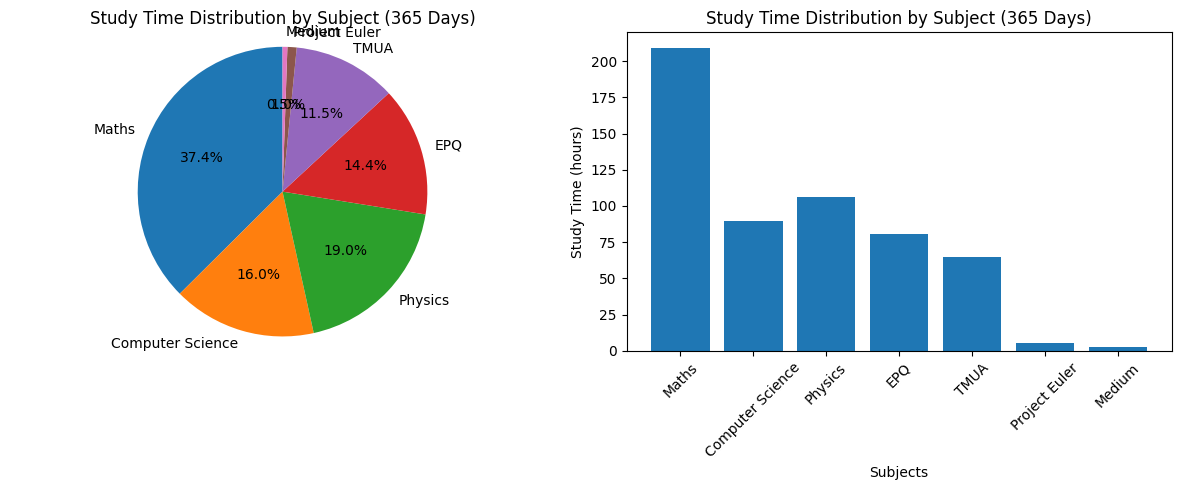

Found 23 events in the past 30 days from Studying.
Found 19 events in the past 30 days from Calendar.
Total study time in the past 30 days: 43.5 hours
Computer Science: 2.5 hrs, TMUA: 32.2 hrs, Project Euler: 5.8 hrs, Medium: 3.0 hrs, 


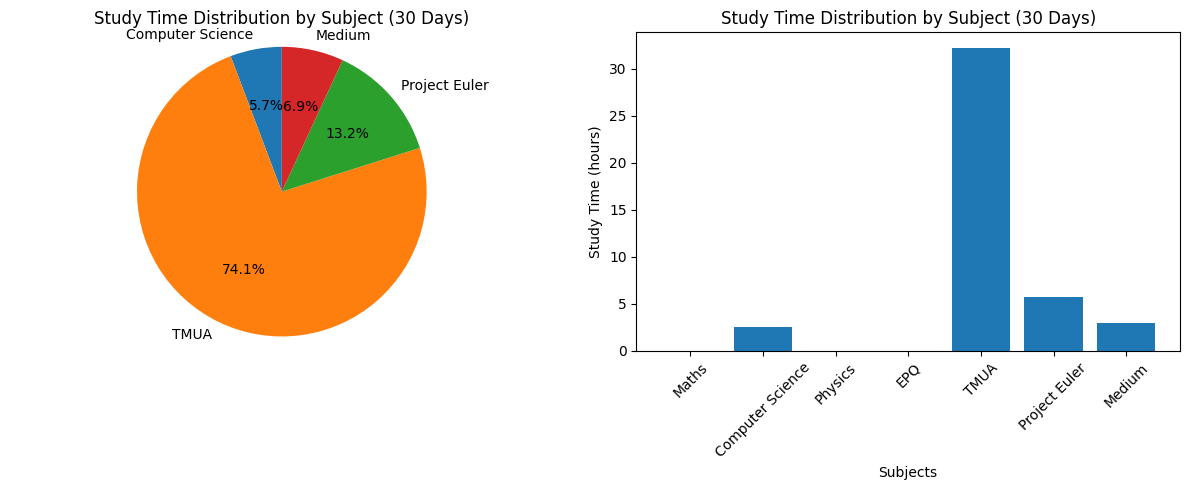

Found 5 events in the past 7 days from Studying.
Found 2 events in the past 7 days from Calendar.
Total study time in the past 7 days: 5.333333333333334 hours
TMUA: 4.1 hrs, Project Euler: 1.2 hrs, 


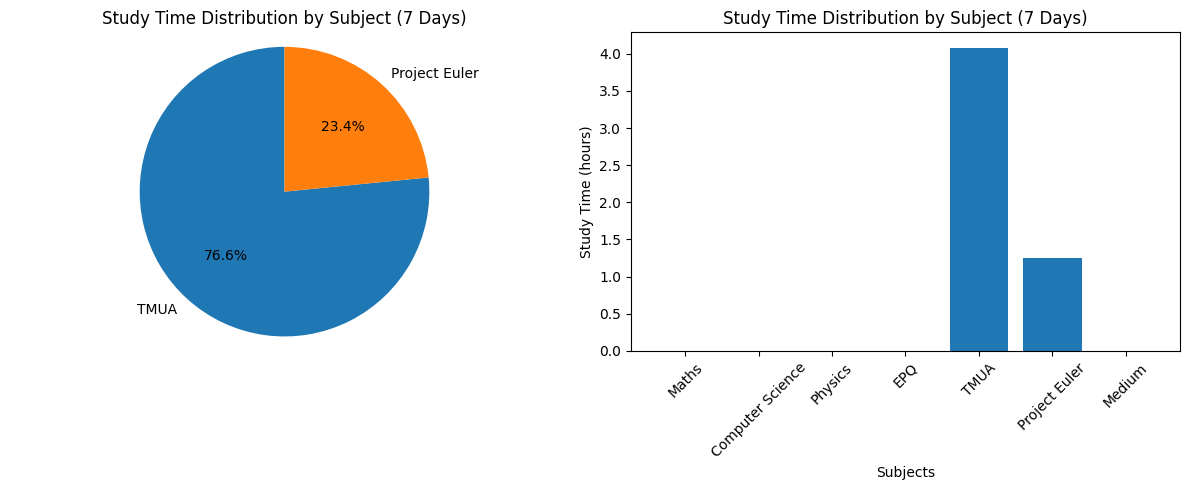

In [48]:
service = authenticate_google_calendar()
calendar_ids = [
    "0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com",
    "billjrimell@gmail.com",
    # "b7ca60b7b46309b1e408a4a240a5456ca98cb4af51ad62d260ae8ae4fd0ce45d@group.calendar.google.com" # timetable
]

# Generate statistics and plots for different time periods
for days in [365, 30, 7]:
    study_stats(service, calendar_ids, num_previous_days=days)

Total studying hours scheduled for today: 5.8 hours
Total studying hours completed today: 0.0 hours
Percentage of planned studying hours completed today: 0%
Total studying hours completed today: 0.0 hours
Average studying hours over the last month: 1.0 hours
Average studying hours over the last week: 1.2 hours


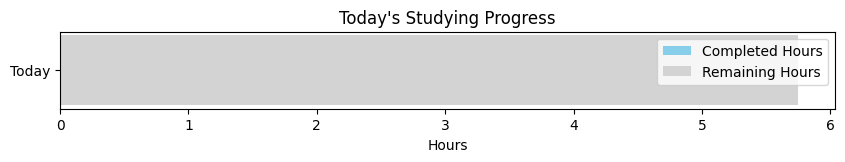

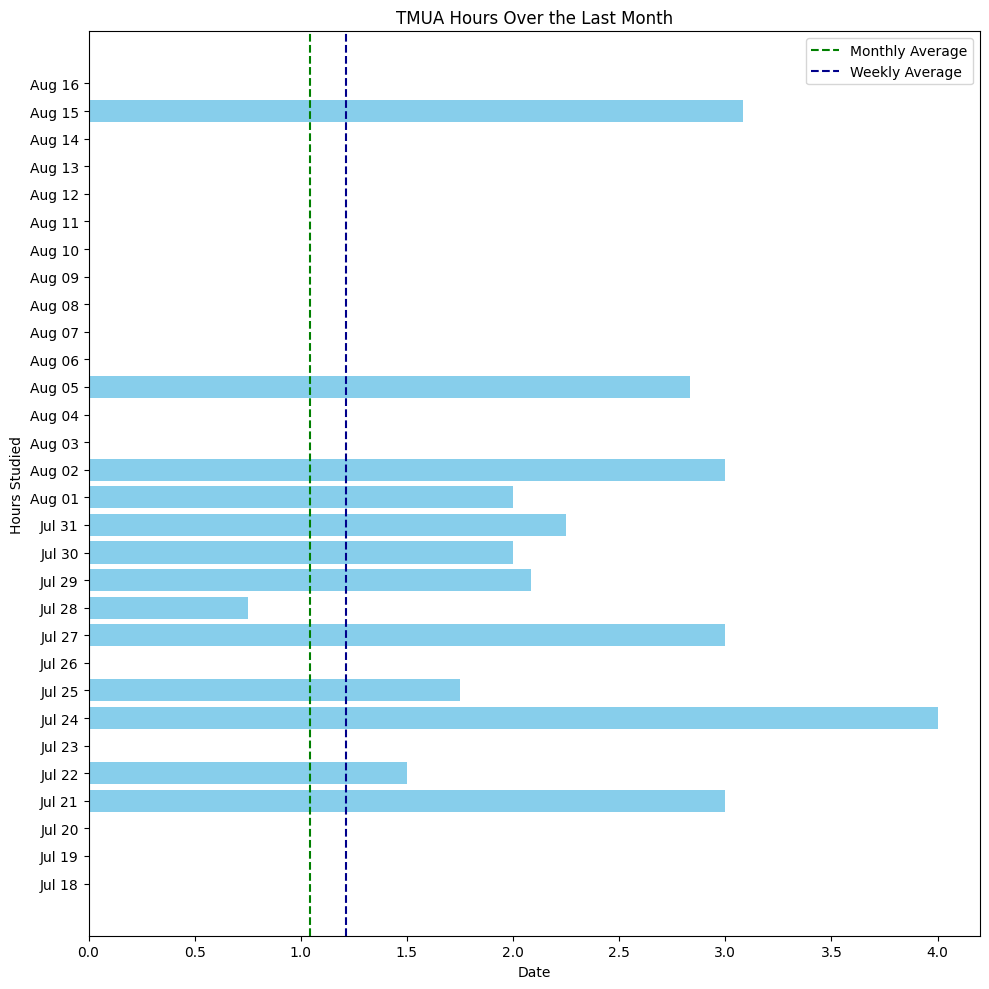

In [45]:
plot_studying_progress(service, calendar_ids[0])
# plot_studying_hours_over_past_month(service, calendar_ids[0])
plot_subject_hours_over_past_month(service, calendar_ids[0], "TMUA", subjects)